%%capture
import sklearn # import before to get new version
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [4]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Two digit

In [5]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)

from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)
rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)

## Model with only negative biases

In [6]:
from braindecode.veganlasagne.layers import print_layers
three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-negative-bias.pkl')

all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(three_layer_model)



 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 Pool2DLayer               (None, 3, 13, 27)
 4 Conv2DLayer               (None, 3, 12, 26)
 5 Pool2DLayer               (None, 3, 6, 13)
 6 Conv2DLayer               (None, 3, 4, 12)
 7 Pool2DLayer               (None, 3, 2, 6)
 8 DenseLayer                (None, 2)


In [7]:
from braindecode.analysis.heatmap import create_heatmap_fn


In [9]:
heatmap_fn = create_heatmap_fn(all_layers[1:], ['z_b'] * 7 + ['z_plus'], min_in=0, max_in=1.)

all_scaled_relevances = []
all_trials = []
for i_trial in xrange(0,20):
    trial = X_train_flat_both[i_trial]
    out_relevances = [y_train_both[i_trial] == 0, y_train_both[i_trial] == 1]
    out_relevances = heatmap_fn(out_relevances, trial)
    scaled_relevance = out_relevances[0] * np.std(trial) / np.std(out_relevances[0])
    all_scaled_relevances.append(scaled_relevance)
    all_trials.append(trial.reshape(28,56))
    

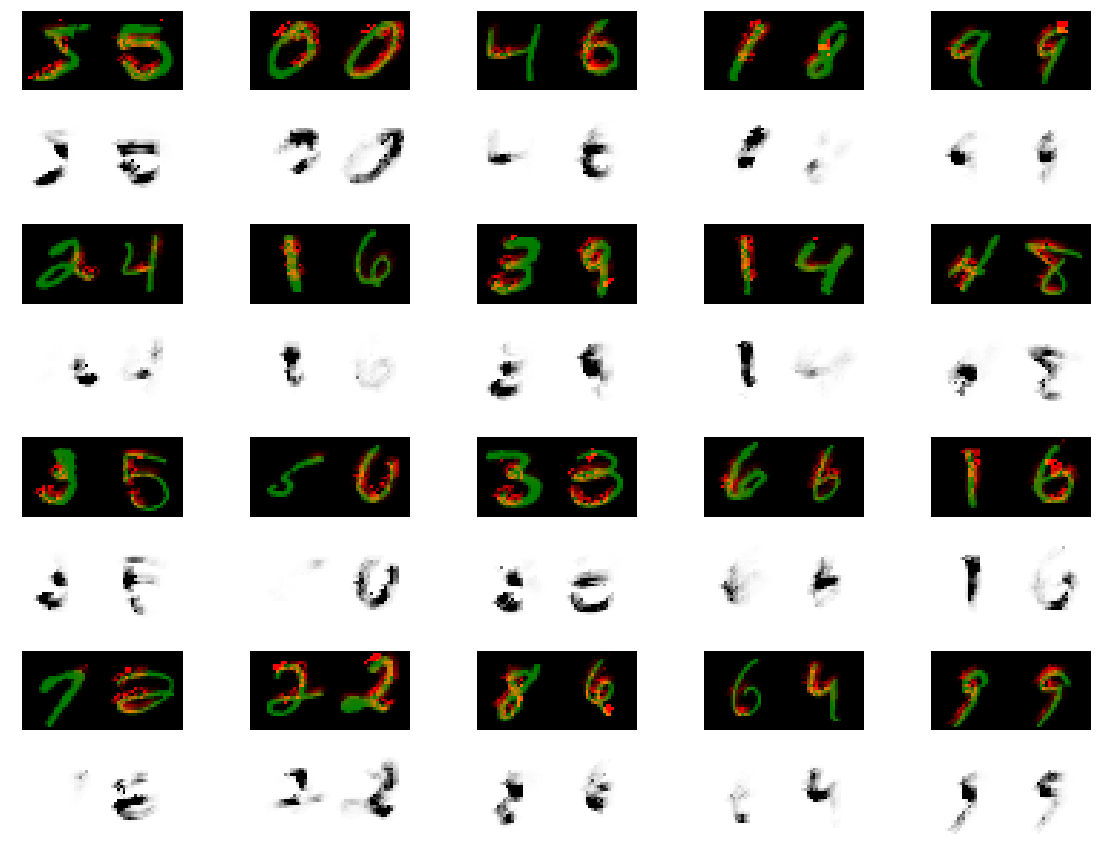

In [10]:
from matplotlib import cm
plt.figure(figsize=(16,12))
n_cols = 5
n_rows = int(np.ceil(len(all_scaled_relevances) / float(n_cols))) * 2
for i_plot in range(len(all_scaled_relevances)):
    scaled_relevance = all_scaled_relevances[i_plot]
    i_row = i_plot // n_cols
    plt.subplot(n_rows, n_cols, i_plot+1 + (i_row) * n_cols)
    trial = all_trials[i_plot]
    together = np.array([scaled_relevance, trial*0.5, trial*0]).transpose(1,2,0)
    plt.imshow(together, interpolation='nearest', vmin=0, vmax=1)
    plt.axis('off')
    plt.subplot(n_rows, n_cols, i_plot+1 + (i_row+1) * n_cols)
    plt.imshow(scaled_relevance, interpolation='nearest', vmin=0, vmax=1, cmap=cm.Greys)
    plt.axis('off')

plt.tight_layout()

In [11]:
heatmap_fn = create_heatmap_fn(all_layers[1:], ['w_sqr'] * 7 + ['z_plus'], min_in=0, max_in=1)

all_scaled_relevances = []
all_trials = []
for i_trial in xrange(0,20):
    trial = X_train_flat_both[i_trial]
    out_relevances = [y_train_both[i_trial] == 0, y_train_both[i_trial] == 1]
    out_relevances = heatmap_fn(out_relevances, trial)
    scaled_relevance = out_relevances[0] * np.std(trial) / np.std(out_relevances[0])
    all_scaled_relevances.append(scaled_relevance)
    all_trials.append(trial.reshape(28,56))
    

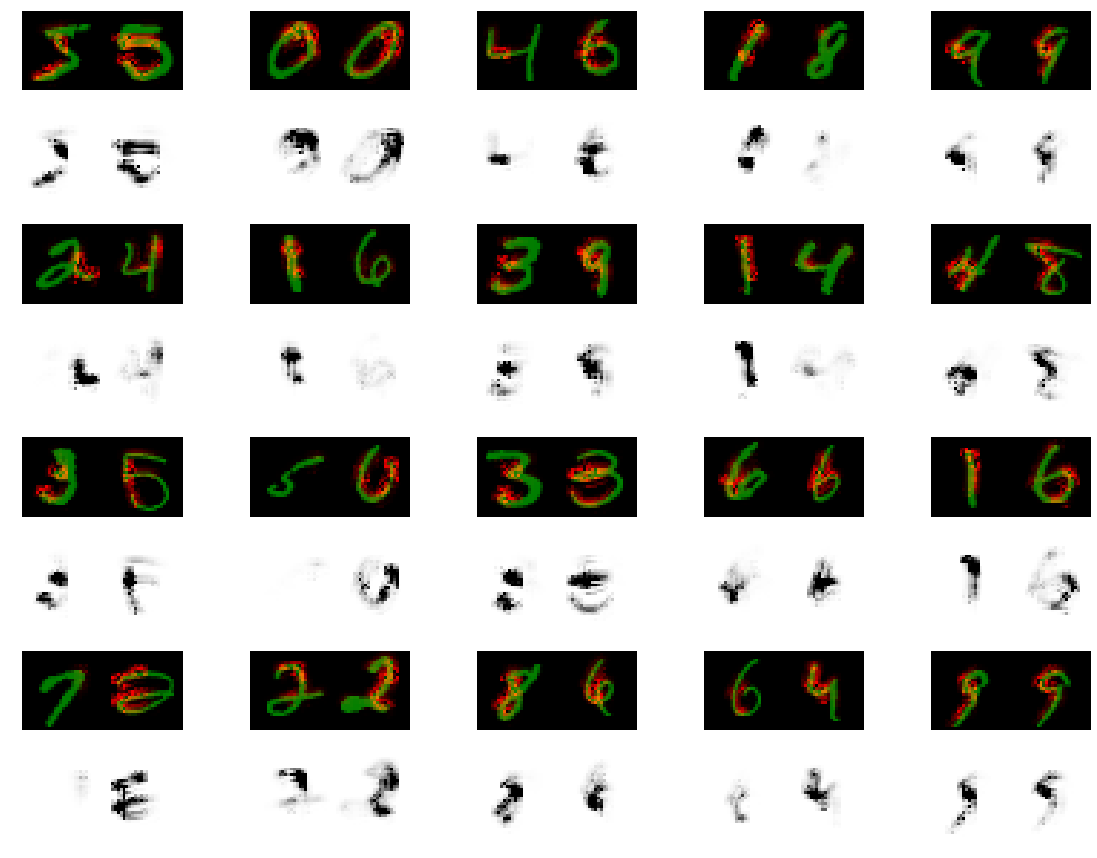

In [12]:
plt.figure(figsize=(16,12))
n_cols = 5
n_rows = int(np.ceil(len(all_scaled_relevances) / float(n_cols))) * 2
for i_plot in range(len(all_scaled_relevances)):
    scaled_relevance = all_scaled_relevances[i_plot]
    i_row = i_plot // n_cols
    plt.subplot(n_rows, n_cols, i_plot+1 + (i_row) * n_cols)
    trial = all_trials[i_plot]
    together = np.array([scaled_relevance, trial*0.5, trial*0]).transpose(1,2,0)
    plt.imshow(together, interpolation='nearest', vmin=0, vmax=1)
    plt.axis('off')
    plt.subplot(n_rows, n_cols, i_plot+1 + (i_row+1) * n_cols)
    plt.imshow(scaled_relevance, interpolation='nearest', vmin=0, vmax=1, cmap=cm.Greys)
    plt.axis('off')

plt.tight_layout()